In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import matplotlib.pyplot as plt
import requests

#from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [3]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'BEAU'

# SM location 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cal_cfsv2/'
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
codepath = SMpath+'code'
micrometFile = SMpath+'code/micromet_code.f'

run_date = '2024-02-09'

In [4]:
# Outfile path
#outpath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
calpath = '/nfs/attic/dfh/2020_NPRB/results/calibration/'+domain+'/prep_files/'
# Figure path
figpath = '/nfs/attic/dfh/2020_NPRB/results/figures/'+domain+'/'
# location of SM forcing data
datapath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

#start calibration date    
st_dt = '2011-10-01'#domains[domain]['st']
#end calibration date
ed_dt = '2018-09-30'#domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [5]:
# # load prec cf df
cfdf = pd.read_csv(datapath + domain+'_precCF_'+st_dt+'_'+ed_dt+'_cfsv2.csv')
cfdf
# calculate weighted correction factor
cf = round(np.nansum(cfdf.cf*cfdf.wt),2)
cf

0.85

In [6]:
gdf = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson')
path = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
df = pd.read_csv(path,parse_dates=True,index_col=0)
# slice swe to calibration time period
#df = df[st_dt:ed_dt]

In [8]:
#data = xr.open_dataset(calpath+'calibration_'+run_date+'_full_set.nc')
data = xr.open_dataset(calpath+'calibration_'+run_date+'.nc')
data

<xarray.Dataset>
Dimensions:          (calibration_run: 252, metric: 5, station: 1)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 4 5 ... 247 248 249 250 251
  * metric           (metric) object 'R2' 'MBE' 'RMSE' 'NSE' 'KGE'
  * station          (station) object '1175_AK_SNTL'
Data variables:
    cal_metrics      (calibration_run, metric, station) float64 ...
Attributes:
    description:             SnowModel line calibration performance metrics
    calibration_parameters:  ro_snowmax,cf_precip_scalar,ro_adjust
    model_parameter:         SWE [m]

In [9]:
#swes = xr.open_dataset(calpath+'swe_'+run_date+'_full_set.nc')
swes = xr.open_dataset(calpath+'swe_'+run_date+'.nc')
swes

<xarray.Dataset>
Dimensions:          (calibration_run: 252, sim_day: 2557, station: 1)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 4 5 ... 247 248 249 250 251
  * sim_day          (sim_day) int64 0 1 2 3 4 5 ... 2552 2553 2554 2555 2556
  * station          (station) object '1175_AK_SNTL'
Data variables:
    cal_metrics      (calibration_run, sim_day, station) float64 ...
Attributes:
    description:      SnowModel swe
    model_parameter:  SWE [m]

In [10]:
#'cal_params_2020-07-03_full_set.csv'
#calibration = pd.read_csv(calpath+'cal_params_'+run_date+'_full_set.csv')
calibration = pd.read_csv(calpath+'cal_params_'+run_date+'.csv')
calibration.head()

,max_layers,lapse_rate,ro_snowmax,ro_adjust,gap_frac,prec_lapse_rate,conifer_lai
0,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,2.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
1,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,3.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
2,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,4.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
3,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,5.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
4,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,6.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8


In [11]:
# # sidebar to find top performance metrics across domains with pr cf = 1
# cf1data = data.sel(calibration_run=calibration.index[calibration.cf_precip_scalar==1])

# NSE = cf1data.cal_metrics.loc[:,"NSE",:]
# nse_top = np.amax(cf1data.cal_metrics.loc[:,"NSE",:],axis = 0)
# KGE = cf1data.cal_metrics.loc[:,"KGE",:]
# kge_top = np.amax(cf1data.cal_metrics.loc[:,"KGE",:],axis = 0)
# RMSE = cf1data.cal_metrics.loc[:,"RMSE",:]
# rmse_top = np.amin(cf1data.cal_metrics.loc[:,"RMSE",:],axis = 0)
# R_2 = cf1data.cal_metrics.loc[:,"R2",:]
# r2_top = np.amax(cf1data.cal_metrics.loc[:,"R2",:],axis = 0)
# MBE = cf1data.cal_metrics.loc[:,"MBE",:]
# mbe_top = np.amin(cf1data.cal_metrics.loc[:,"MBE",:],axis = 0)
# print(nse_top)

# x = np.empty((len(cf1data.calibration_run),5))
# x[:,0] = np.mean(NSE.values,axis=1)
# x[:,1] = np.mean(KGE,axis=1).values
# x[:,2] = np.mean(RMSE,axis=1).values
# x[:,3] = np.mean(R_2,axis=1).values
# x[:,4] = np.mean(MBE,axis=1).values

# dataav = pd.DataFrame(x,columns=['NSE', 'KGE', 'RMSE','R_2','MBE'])

# def get_top_idx(metric):
#     if (metric == 'R_2') | (metric == 'NSE')|(metric == 'KGE'):
#         x = dataav[metric].values
#         index = np.where(x==np.max(x))
#     elif (metric == 'MBE'):
#         x = np.abs(dataav['MBE']).values
#         index = np.where(x==np.min(x))
#     elif (metric == 'RMSE'):
#         x = dataav[metric]
#         index = np.where(x==np.min(x))
#     return index[0][0]


# top_params = []

# top_params.append(get_top_idx('R_2'))
# top_params.append(get_top_idx('MBE'))
# top_params.append(get_top_idx('RMSE'))
# top_params.append(get_top_idx('NSE'))
# top_params.append(get_top_idx('KGE'))

# print(domain)
# cal_subset = calibration[calibration.cf_precip_scalar==1]
# topav = cal_subset.iloc[top_params]
# topav = topav.reset_index(drop=True)
# topav

# Find average top performing metrics 
For a given OF, take the average skill score across all stations

In [12]:
NSE = data.cal_metrics.loc[:,"NSE",:]
nse_top = np.amax(data.cal_metrics.loc[:,"NSE",:],axis = 0)
KGE = data.cal_metrics.loc[:,"KGE",:]
kge_top = np.amax(data.cal_metrics.loc[:,"KGE",:],axis = 0)
RMSE = data.cal_metrics.loc[:,"RMSE",:]
rmse_top = np.amin(data.cal_metrics.loc[:,"RMSE",:],axis = 0)
R_2 = data.cal_metrics.loc[:,"R2",:]
r2_top = np.amax(data.cal_metrics.loc[:,"R2",:],axis = 0)
MBE = data.cal_metrics.loc[:,"MBE",:]
mbe_top = np.amin(data.cal_metrics.loc[:,"MBE",:],axis = 0)

print('maxNSE:', r2_top)

maxNSE: <xarray.DataArray 'cal_metrics' (station: 1)>
array([0.5713513])
Coordinates:
    metric   <U2 'R2'
  * station  (station) object '1175_AK_SNTL'


Text(0.5, 1.0, 'R**2')

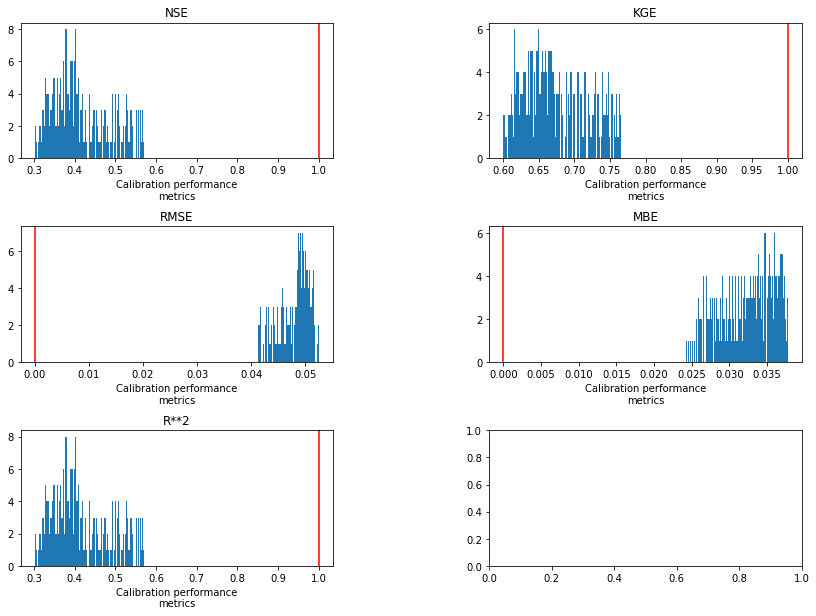

In [13]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axes[0,0].axvline(1,c='r') 
NSE.plot.hist(ax=axes[0,0],bins=100)
axes[0,0].set_title('NSE')
axes[0,1].axvline(1,c='r') 
KGE.plot.hist(ax=axes[0,1],bins=100)
axes[0,1].set_title('KGE')
axes[1,0].axvline(0,c='r') 
RMSE.plot.hist(ax=axes[1,0],bins=100)
axes[1,0].set_title('RMSE')
axes[1,1].axvline(0,c='r') 
MBE.plot.hist(ax=axes[1,1],bins=100)
axes[1,1].set_title('MBE')
axes[2,0].axvline(1,c='r') 
R_2.plot.hist(ax=axes[2,0],bins=100)
axes[2,0].set_title('R**2')

In [14]:
#fig.savefig(figpath+domain+'_domain_cal_metrics.pdf', format='pdf', dpi=300)

### Data frame of metrics averaged over domain for each model run

In [15]:
x = np.empty((len(calibration),5))
x[:,0] = np.mean(NSE.values,axis=1)
x[:,1] = np.mean(KGE,axis=1).values
x[:,2] = np.mean(RMSE,axis=1).values
x[:,3] = np.mean(R_2,axis=1).values
x[:,4] = np.mean(MBE,axis=1).values

dataav = pd.DataFrame(x,columns=['NSE', 'KGE', 'RMSE','R_2','MBE'])
dataav
#dataav.to_csv('calibration_params.csv')

,NSE,KGE,RMSE,R_2,MBE
0,0.530502,0.744266,0.043146,0.530502,0.026606
1,0.538457,0.749657,0.042779,0.538457,0.025882
2,0.544370,0.753422,0.042504,0.544370,0.025412
3,0.551703,0.757106,0.042165,0.551703,0.025167
4,0.556560,0.759992,0.041936,0.556560,0.024810
...,...,...,...,...,...
247,0.326867,0.615259,0.051548,0.326867,0.037038
248,0.331552,0.618364,0.051369,0.331552,0.036825
249,0.338738,0.622955,0.051092,0.338738,0.036557
250,0.345460,0.627203,0.050831,0.345460,0.036313


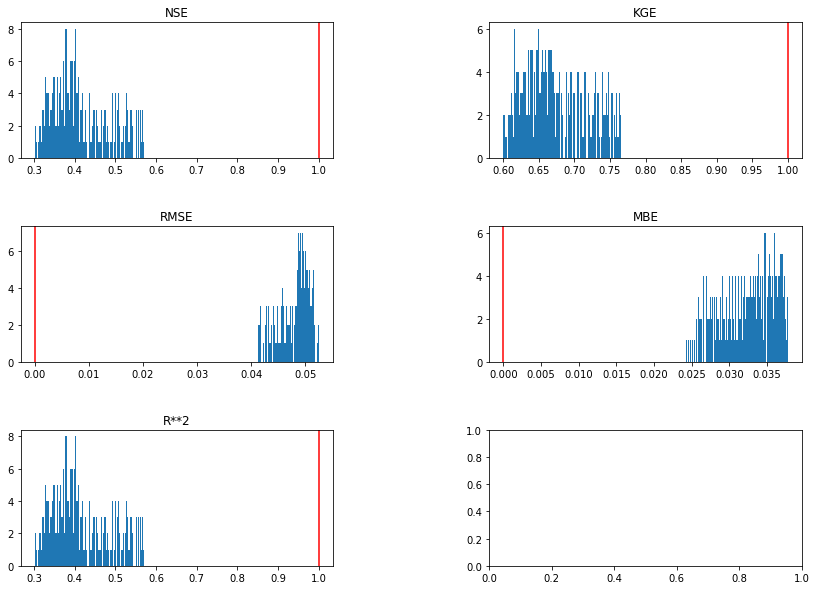

In [16]:
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs[0, 0].hist(dataav['NSE'],bins=100)
axs[0, 0].set_title('NSE')
axs[0, 0].axvline(1,c='r') 
axs[0, 1].hist(dataav['KGE'],bins=100)
axs[0, 1].set_title('KGE')
axs[0, 1].axvline(1,c='r') 
axs[1, 0].hist(dataav['RMSE'],bins=100)
axs[1, 0].set_title('RMSE')
axs[1, 0].axvline(0,c='r') 
axs[1, 1].hist(dataav['MBE'],bins=100)
axs[1, 1].set_title('MBE')
axs[1, 1].axvline(0,c='r') 
axs[2, 0].hist(dataav['R_2'],bins=100)
axs[2, 0].set_title('R**2')
axs[2, 0].axvline(1,c='r') 

In [17]:
#fig.savefig(figpath+domain+'_domain_cal_metrics_averaged.pdf', format='pdf', dpi=300)

In [18]:
def get_top_idx(metric):
    if (metric == 'R_2') | (metric == 'NSE')|(metric == 'KGE'):
        x = dataav[metric].values
        index = np.where(x==np.max(x))
    elif (metric == 'MBE'):
        x = np.abs(dataav['MBE']).values
        index = np.where(x==np.min(x))
    elif (metric == 'RMSE'):
        x = dataav[metric]
        index = np.where(x==np.min(x))
    return index[0][0]


top_params = []

top_params.append(get_top_idx('R_2'))
top_params.append(get_top_idx('MBE'))
top_params.append(get_top_idx('RMSE'))
top_params.append(get_top_idx('NSE'))
top_params.append(get_top_idx('KGE'))

top_params

[174, 6, 174, 174, 6]

In [19]:
#the parameters for the top performing runs
print(domain)
topav = calibration.iloc[top_params]
topav = topav.reset_index(drop=True)
topav

BEAU


,max_layers,lapse_rate,ro_snowmax,ro_adjust,gap_frac,prec_lapse_rate,conifer_lai
0,20,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,8.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
1,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,8.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
2,20,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,8.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
3,20,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,8.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8
4,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,8.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8


### Heatmap of top performing runs 

In [20]:
#https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


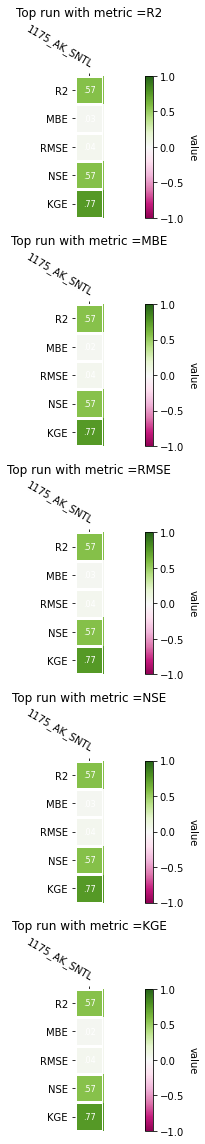

In [21]:
Metrics = ['R2','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")
#WA figsize=(8,16)
fig, ((ax), (ax1), (ax2), (ax3),(ax4)) = plt.subplots(5, 1, figsize=(12,16))

# Replicate the above example with a different font size and colormap.
im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top run with metric ='+Metrics[0])

im, _ = heatmap(data.cal_metrics[top_params[1],:,:], Metrics, Stations, ax=ax1,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax1.set_title('Top run with metric ='+Metrics[1])

im, _ = heatmap(data.cal_metrics[top_params[2],:,:], Metrics, Stations, ax=ax2,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax2.set_title('Top run with metric ='+Metrics[2])

im, _ = heatmap(data.cal_metrics[top_params[3],:,:], Metrics, Stations, ax=ax3,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax3.set_title('Top run with metric ='+Metrics[3])

im, _ = heatmap(data.cal_metrics[top_params[4],:,:], Metrics, Stations, ax=ax4,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax4.set_title('Top run with metric ='+Metrics[4])


plt.tight_layout()
plt.show()

In [21]:
#fig.savefig(figpath+domain+'_heatmap_averaged.pdf', format='pdf', dpi=300)

## SWE timeseries with optimal configurations identified above

In [22]:
inswe = swes.cal_metrics[top_params,:,:]
#inswe = inswe.reset_index(drop=True)
inswe

<xarray.DataArray 'cal_metrics' (calibration_run: 5, sim_day: 2557, station: 1)>
array([[[0.000111],
        [0.000139],
        ...,
        [0.      ],
        [0.      ]],

       [[0.000111],
        [0.000139],
        ...,
        [0.      ],
        [0.      ]],

       ...,

       [[0.000111],
        [0.000139],
        ...,
        [0.      ],
        [0.      ]],

       [[0.000111],
        [0.000139],
        ...,
        [0.      ],
        [0.      ]]])
Coordinates:
  * calibration_run  (calibration_run) int64 174 6 174 174 6
  * sim_day          (sim_day) int64 0 1 2 3 4 5 ... 2552 2553 2554 2555 2556
  * station          (station) object '1175_AK_SNTL'
Attributes:
    long_name:      swe timeseries [m]
    standard_name:  swe

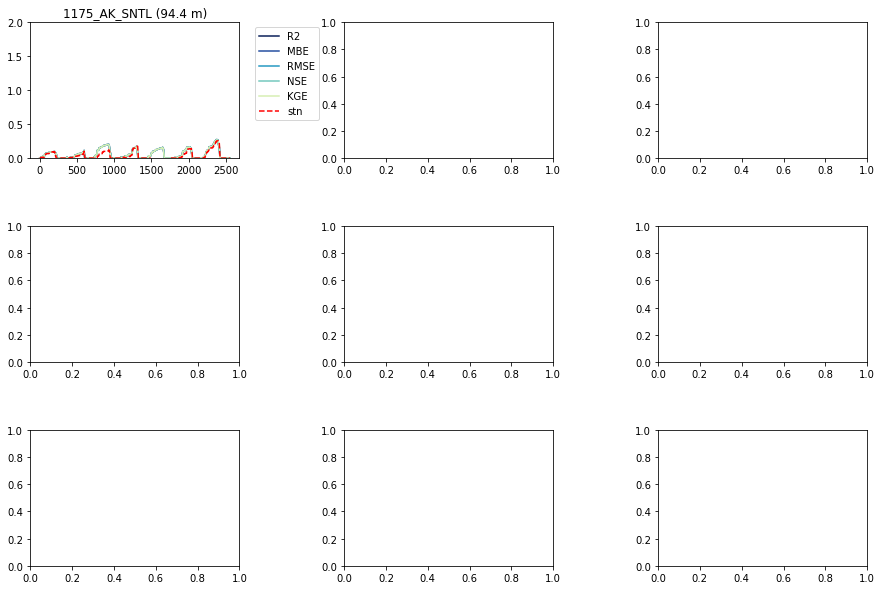

In [24]:
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
#CO_N: nrows=13,figsize=(15, 34) 
# MT: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=3, figsize=(15, 10) , ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = inswe.sel(station = nam).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    for j in range(n):
        c=next(color)
        axs[i].plot(np.transpose(mod[j,:]),c=c)
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(['R2','MBE','RMSE','NSE', 'KGE','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [24]:
fig.savefig(figpath+domain+'_SWE_top_calmetrics_'+run_date+'_av.pdf', format='pdf', dpi=300)

# Top ranked score

-> each OF is ranked independently

-> the rank scores are summed across each model run 

-> The summed scores are then ranked and the top scores are used to identify the top model parameter combinations

In [25]:
dataav['NSE_rank']=dataav['NSE'].rank(ascending=False)
dataav['KGE_rank']=dataav['KGE'].rank(ascending=False)
dataav['R_2_rank']=dataav['R_2'].rank(ascending=False)
dataav['RMSE_rank']=dataav['RMSE'].rank()
dataav['MBE_rank']=np.abs(dataav['MBE']).rank()
dataav['score']=dataav['NSE_rank']+ dataav['KGE_rank']+dataav['R_2_rank']+ dataav['RMSE_rank']+dataav['MBE_rank']
dataav['score_rank'] = dataav['score'].rank()
dataav.head()

,NSE,KGE,RMSE,R_2,MBE,NSE_rank,KGE_rank,R_2_rank,RMSE_rank,MBE_rank,score,score_rank
0,0.530502,0.744266,0.043146,0.530502,0.026606,26.0,25.0,26.0,26.0,19.0,122.0,25.0
1,0.538457,0.749657,0.042779,0.538457,0.025882,20.0,16.0,20.0,20.0,8.0,84.0,16.0
2,0.544370,0.753422,0.042504,0.544370,0.025412,15.0,13.0,15.0,15.0,5.0,63.0,13.0
3,0.551703,0.757106,0.042165,0.551703,0.025167,12.0,10.0,12.0,12.0,4.0,50.0,10.0
4,0.556560,0.759992,0.041936,0.556560,0.024810,10.0,7.0,10.0,10.0,3.0,40.0,8.0


In [26]:
rank_params = np.where((dataav['score_rank']==min(dataav['score_rank'])))
top_params = rank_params[0]
label = dataav['score_rank'][top_params].values
top_params

array([174])

In [27]:
#the parameters for the top performing runs
toprank = calibration.iloc[top_params]
#toprank = dataav.iloc[top_params]
toprank

,max_layers,lapse_rate,ro_snowmax,ro_adjust,gap_frac,prec_lapse_rate,conifer_lai
174,20,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7",350.0,8.0,0.2,"0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",1.8


Text(0.5, 1.0, 'Top Rank')

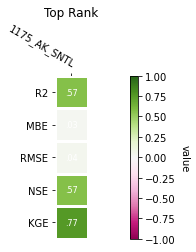

In [28]:
fig, ((ax)) = plt.subplots(1, 1, figsize=(15,3))

# Replicate the above example with a different font size and colormap.
im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top Rank')

In [152]:
fig.savefig(figpath+domain+'_heatmap_rank.pdf', format='pdf', dpi=300)

In [97]:
# #this worked with a smaller calibration parameter set but does not work if their are ties for first place rankings
# rank_params = np.where((dataav['score_rank']==1)|(dataav['score_rank']==2)|(dataav['score_rank']==3))

In [29]:
inswe = swes.cal_metrics[top_params[0],:,:]
inswe

<xarray.DataArray 'cal_metrics' (sim_day: 2557, station: 1)>
array([[0.000111],
       [0.000139],
       [0.000121],
       ...,
       [0.      ],
       [0.      ],
       [0.      ]])
Coordinates:
    calibration_run  int64 174
  * sim_day          (sim_day) int64 0 1 2 3 4 5 ... 2552 2553 2554 2555 2556
  * station          (station) object '1175_AK_SNTL'
Attributes:
    long_name:      swe timeseries [m]
    standard_name:  swe

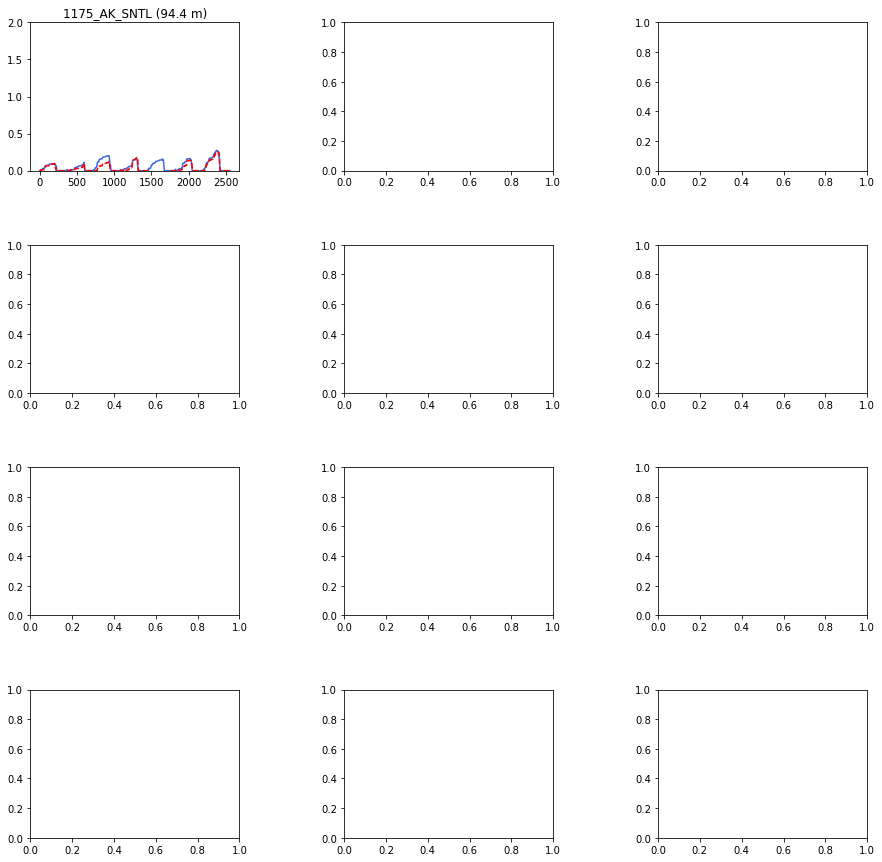

In [30]:
#Ranking plot OR -> one winning rank score 
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0]

fig, axs = plt.subplots(nrows=4, figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = inswe[:,i]
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+2)))
    axs[i].plot(mod,c='royalblue')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
#     if i == 0:
#         axs[i].legend([str(label[0]),str(label[1]),str(label[2]),'stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [100]:
fig.savefig(figpath+domain+'_SWE_top_calmetrics_'+run_date+'_rank.pdf', format='pdf', dpi=300)

# Set up full run of SM based on above findings

In [31]:
OF = 'KGE'

#the parameters for the top performing runs
calibration.loc[get_top_idx(OF)]

max_layers                                                         1
lapse_rate           4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7
ro_snowmax                                                       350
ro_adjust                                                          8
gap_frac                                                         0.2
prec_lapse_rate    0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...
conifer_lai                                                      1.8
Name: 6, dtype: object

In [32]:
# save for later use
caldf=calibration.loc[get_top_idx(OF)]
caldf.to_csv(calpath+OF+'_top_params_'+run_date+'_cfsv2.csv')

In [34]:
# SM location 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
codepath = SMpath+'code'
micrometFile = SMpath+'code/micromet_code.f'

In [35]:
#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value,parFile):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108 \
    or par_dict[parameter][2] == 147 or par_dict[parameter][2] == 148 \
    or par_dict[parameter][2] == 149:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()
    
#base .par
with open('/nfs/attic/dfh/2020_NPRB/data/json/par_base.json') as f:
    base = json.load(f)

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(int(domains[domain]['ncols'])+1)
             +',ny_max='+str(int(domains[domain]['nrows'])+1)+')\n')#full domain
replace_line(micrometFile, 3347,'      data vlai_summer /'+str(calibration.conifer_lai.loc[get_top_idx(OF)])+', 2.5, 2.5, 1.5, 1.0/\n')
replace_line(micrometFile, 3348,'      data vlai_winter /'+str(calibration.conifer_lai.loc[get_top_idx(OF)])+', 0.5, 1.5, 1.5, 1.0/\n')

#remove line flag
edit_par(base,'snowmodel_line_flag',0,parFile)
edit_par(base,'topo_ascii_fname','../../data/SMinputs/'+domain+'/'+domain+'_dem.asc',parFile)
edit_par(base,'veg_ascii_fname','../../data/SMinputs/'+domain+'/'+domain+'_veg.asc',parFile)
edit_par(base,'lat_file_path','../../data/SMinputs/'+domain+'/'+domain+'_grid_lat.asc',parFile)
edit_par(base,'lon_file_path','../../data/SMinputs/'+domain+'/'+domain+'_grid_lon.asc',parFile)
edit_par(base,'nx',domains[domain]['ncols'],parFile)
edit_par(base,'ny',domains[domain]['nrows'],parFile)
#edit_par(base,'lat_solar_flag',calibration.lat_solar_flag.loc[get_top_idx(OF)])
#edit_par(base,'wind_lapse_rate',calibration.wind_lapse_rate.loc[get_top_idx(OF)])
edit_par(base,'lapse_rate',calibration.lapse_rate.loc[get_top_idx(OF)],parFile)
edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate.loc[get_top_idx(OF)],parFile)
edit_par(base,'max_layers',calibration.max_layers.loc[get_top_idx(OF)],parFile)
edit_par(base,'ro_snowmax',calibration.ro_snowmax.loc[get_top_idx(OF)],parFile)
edit_par(base,'ro_adjust',calibration.ro_adjust.loc[get_top_idx(OF)],parFile) 
edit_par(base,'gap_frac',calibration.gap_frac.loc[get_top_idx(OF)],parFile) 
edit_par(base,'print_var_01','y',parFile)#tair
edit_par(base,'print_var_09','y',parFile)#prec
edit_par(base,'print_var_10','n',parFile)#rain
edit_par(base,'print_var_11','n',parFile)#sprec
edit_par(base,'print_var_12','n',parFile)#swemelt
edit_par(base,'print_var_14','y',parFile)#runoff
edit_par(base,'print_var_18','y',parFile)#swed
edit_par(base,'print_var_19','y',parFile)#sspr
edit_par(base,'print_var_20','n',parFile)#ssmt
edit_par(base,'print_var_13','y',parFile)#subl
edit_par(base,'cf_precip_flag',3,parFile)
edit_par(base,'cf_precip_scalar',cf,parFile) 
#edit_par(base,'run_snowtran',1,parFile)


    
## run compile script 
## Compile SnowModel

# %cd $codepath
# ! ./compile_snowmodel.script
# %cd  $calpath